In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from src.preprocessing.process_sounds_metadata import generate_sounds_metadata, make_fixed_size_sounds
from src.preprocessing.filters import filter_recs_metadata
from src.preprocessing.load_data import load_recs_dict, load_sounds
from src.deep_learning.create_model import create_conv_model
from src.data_representations.process_wavs import *
from src.data_representations.process_images import *
from src.deep_learning.vae import VAE
import torch
from torch.utils.data import DataLoader
import umap
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from src.deep_learning.util import *
from src.visualization.plot_softchirps import plot
from notebooks.analysis.plotting_config import ORDER, COLOR
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
import pandas as pd
from src.preprocessing.load_data import *
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata
from src.data_analysis.softchirps_classification import classify, make_bins
%matplotlib inline


In [7]:
dates = 'all'
colonies = ['baratheon', 'targaryen', 'martell', 'lannister', 'arryn', 'stark']
stages = ['labeled and checked', 'traced', 'traced and checked']
experiments = 'all'
sr = 22050

path_to_model = PATH_TO_PROJECT + 'models/vae/'
model_name = 'lab_all-classes'  # i.g. nmr_all-classes or hvd_all-classes 

In [3]:
path_to_recordings_metadata = PATH_TO_PROJECT + '/data/recordings_metadata.csv'
recs_metadata = pd.read_csv(path_to_recordings_metadata)
info = load_info_file(PATH_TO_PROJECT + '/data/rat_info.csv')
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_for_training = recs_metadata[mask]
recs_dict = load_recs_dict(recs_for_training)
sounds_metadata_raw = generate_sounds_metadata(recs_for_training).reset_index(drop=True)

/home/gr1/nmr/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [4]:
p = {'num_freq_bins': 128,
     'num_time_bins': 128,
     'nperseg': 512, 
     'noverlap': 256, # FF
     'min_freq': 2000,
     'max_freq': 10000,
     'spec_min_val': -15, 
     'spec_max_val': 0}


classes_to_use = ['softchirp', 'loudchirp', 'downsweep', 'whistle', 'upsweep', 'combo', 'combotwo']
classes_to_use = 'all'
classes_to_drop = ['noise', 'RFIDscanner', 'weirdo', 'multiplesoftchirps', 'badsplit', 
                   'multipleloudchirp', 'multipleloudchirps', 'multiplecombos']

if classes_to_use != 'all':
    sounds_metadata = sounds_metadata_raw[sounds_metadata_raw['cl'].isin(classes_to_use)].reset_index(drop=True)
else:
    sounds_metadata = sounds_metadata_raw
if classes_to_drop:
    sounds_metadata = sounds_metadata[~sounds_metadata['cl'].isin(classes_to_drop)].reset_index(drop=True)
    
max_softchirps = 100000
softchirps_inds = np.where(sounds_metadata['cl'] == 'softchirp')[0]
np.random.shuffle(softchirps_inds)
sounds_metadata = sounds_metadata.drop(softchirps_inds[max_softchirps :]).reset_index(drop=True)

max_weirdos = 1000000
weirdos_inds = np.where(sounds_metadata['cl'] == 'weirdo')[0]
np.random.shuffle(weirdos_inds)
sounds_metadata = sounds_metadata.drop(weirdos_inds[max_weirdos :]).reset_index(drop=True)


max_size = 30000
for cl, cl_size in sounds_metadata['cl'].value_counts().items():
    if cl_size >= max_size:
        cl_inds = np.where(sounds_metadata['cl'] == cl)[0]
        np.random.shuffle(cl_inds)
        sounds_metadata = sounds_metadata.drop(cl_inds[max_size :]).reset_index(drop=True)
        
sounds_metadata['s'] = sounds_metadata['s'].apply(lambda x: int(sr * x))
sounds_metadata['e'] = sounds_metadata['e'].apply(lambda x: int(sr * x))
sounds_metadata = extend_sounds_metadata(sounds_metadata, info)
#sounds_metadata = sounds_metadata[sounds_metadata['ratids'] == '8318_8388'].reset_index(drop=True)
print(sounds_metadata['cl'].value_counts())
spec_train_aug = create_specs_new(sounds_metadata, recs_dict, p, sr=22050)


softchirp          30000
loudchirp           2720
downsweep           1709
pupcombo            1337
grunt                857
whistle              779
upsweep              466
combo                464
combotwo             422
pupcheveron          279
scream               201
pupsquawk            150
mordent               76
phee                  73
hiccup                60
tweet                 53
vtrill                33
invertedmordent       10
Name: cl, dtype: int64


/home/gr1/nmr/lib/python3.6/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 512 is greater than input length  = 511, using nperseg = 511
  .format(nperseg, input_length))


In [5]:
model = VAE(save_dir='.', lr=7e-4, z_dim=32, model_precision=10.0, device_name="auto")
model.load_state(path_to_model + model_name)

data = [torch.from_numpy(S, ).cuda().float() for S in spec_train_aug]
dl_test = DataLoader(data, batch_size=1, shuffle=False, sampler=None,)
latent_features = model.get_latent(dl_test)
latend_features_scaled = StandardScaler().fit_transform(latent_features)


In [6]:
sounds_metadata['ratids'][sounds_metadata['ratids'].apply(lambda x: len(x) < 5)].value_counts()[:20]

4186    450
4166    371
4008    353
4199    336
4195    318
4444    261
4197    261
2091    254
4194    243
4075    223
8318    219
4057    187
8406    142
2197    125
9449    123
8476    120
3523    117
3481    110
9478    110
9453    108
Name: ratids, dtype: int64

In [58]:
# # what data to use, specify here 
metadata = sounds_metadata
print('Keys: ', list(metadata.columns))

classify_by = 'ratids'
group_by = 'date'
group_by = None
balance = True 
cv_n_folds = 3
analyse_fosters = False
cmap = plt.cm.Blues
foster_colonies = 'all'
foster_ids = ['4057', '4075', '3523', '3481', '3513']
ages_foster = (180, np.inf)
use_umap = False

# specify filters
colonies = 'all'
colonies = ['arryn']
weights = 'all'
dates = 'all'
sexes = 'all' 
ages = 'all' 
ranks = 'all' 
ratids =  'all'
#ratids = ['9478']
excludeids = None 
bodylengths = 'all'
bodylengths2 = 'all' 
sounds_per_rat = [0, 10000]
types = 'single'
classes = 'all'
classes = ['softchirp']
mask =  filter_sounds_metadata_extended(sounds_metadata, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
if classes != 'all':
    mask *= sounds_metadata['cl'].isin(classes)
print(mask.sum())

metadata = metadata[mask].reset_index(drop=True)
features = pd.DataFrame(latend_features_scaled[mask], columns=['dim#%d' % i 
                                                              for i in range(latend_features_scaled.shape[1])])
features_to_classify = list(features.columns)
mask = np.ones(metadata.shape[0], dtype='bool')

if use_umap:
    transform = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, metric='euclidean', random_state=42)
    features = transform.fit_transform(features.values)
    features = pd.DataFrame(features, columns=['dim#1', 'dim#2'])
    features_to_classify = list(features.columns)

mask_foster = filter_sounds_metadata_extended(metadata, foster_ids, None, types, 
                                              foster_colonies, weights, sexes, ages_foster, ranks, dates,
                                              bodylengths, bodylengths2, 'all')
order = ORDER[classify_by]
color = COLOR[classify_by]
color_dict = COLOR[classify_by]
if False:  # BINNING OF CLASSIFY COLUMN
    binsize = 10
    mask_index = metadata[mask].index
    metadata.loc[mask_index, classify_by] = make_bins(metadata[mask][classify_by], binsize)
if False:  # BINNING OF GROUP COLUMN
    binsize = 10 
    metadata[mask][group_by] = make_bins(metadata[mask][group_by], binsize)
    
print_info = False
clf, foster_probs, y_unique, y_unique_foster = classify(features, metadata, mask, mask_foster, 
                                                        order, classify_by,  'all', group_by,
                                                        balance, cv_n_folds, analyse_fosters, print_info, cmap)



print('\nFeatures importances:', )
for fn, fimp in zip(features_to_classify, clf.feature_importances_):
    print('%s: %.3f' % (fn, fimp))

if analyse_fosters:
    prediction = clf.predict_proba(features[features_to_classify][mask_foster])
    prediction = np.concatenate([prediction, 
                                 np.zeros((len(prediction), len(y_unique_foster) - len(y_unique)))], 1)
    foster_predictions = pd.DataFrame(prediction, columns = y_unique_foster)
    foster_predictions['ratids'] = metadata[mask_foster]['ratids'].reset_index(drop = True)
    foster_predictions['age'] = metadata[mask_foster]['age'].reset_index(drop = True)
plt.savefig("test.svg", format="svg")

Keys:  ['s', 'e', 'cl', 'rec', 'colony', 'ratids', 'date', 'experiment', 'weight', 'sex', 'rank', 'dob', 'age', 'bodylength', 'bodylength2']
395
For 827 only one fold [[0]]


ValueError: need at least one array to concatenate

In [59]:
metadata[metadata['ratids']=='827']

,s,e,cl,rec,colony,ratids,date,experiment,weight,sex,rank,dob,age,bodylength,bodylength2
24,137172,141498,softchirp,arryn_24-05-19_0827_0000001.npy,arryn,827,24-05-19,single rat softchirps,51.6,M,rank3,16.03.95,-27690.0,130.0,105.0
25,480058,486643,softchirp,arryn_24-05-19_0827_0000001.npy,arryn,827,24-05-19,single rat softchirps,51.6,M,rank3,16.03.95,-27690.0,130.0,105.0
26,590723,596024,softchirp,arryn_24-05-19_0827_0000001.npy,arryn,827,24-05-19,single rat softchirps,51.6,M,rank3,16.03.95,-27690.0,130.0,105.0
27,718738,723177,softchirp,arryn_24-05-19_0827_0000001.npy,arryn,827,24-05-19,single rat softchirps,51.6,M,rank3,16.03.95,-27690.0,130.0,105.0
28,740217,744606,softchirp,arryn_24-05-19_0827_0000001.npy,arryn,827,24-05-19,single rat softchirps,51.6,M,rank3,16.03.95,-27690.0,130.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1135663,1141043,softchirp,arryn_26-09-18_0827_0000025.npy,arryn,827,26-09-18,classification,51.6,M,rank3,16.03.95,-27930.0,130.0,105.0
363,1160623,1166445,softchirp,arryn_26-09-18_0827_0000025.npy,arryn,827,26-09-18,classification,51.6,M,rank3,16.03.95,-27930.0,130.0,105.0
364,1209663,1216719,softchirp,arryn_26-09-18_0827_0000025.npy,arryn,827,26-09-18,classification,51.6,M,rank3,16.03.95,-27930.0,130.0,105.0
365,1275813,1283045,softchirp,arryn_26-09-18_0827_0000025.npy,arryn,827,26-09-18,classification,51.6,M,rank3,16.03.95,-27930.0,130.0,105.0


Keys:  ['s', 'e', 'cl', 'rec', 'colony', 'ratids', 'date', 'experiment']
5905


/home/gr1/Projects/Naked-mole-rat-voices/src/util.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(indexes)


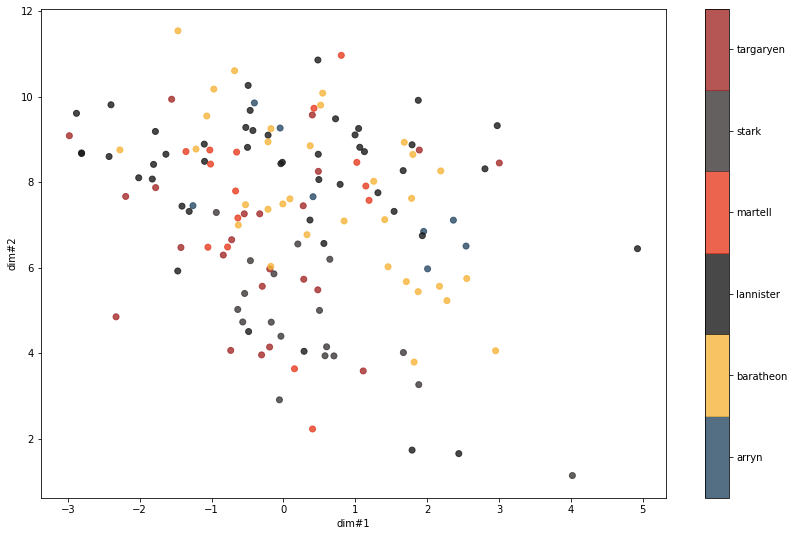

In [54]:

# specify what is ploted
print('Keys: ', list(sounds_metadata.columns))
# specify filters
colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' 
ages = 'all' 
ranks = 'all' 
ratids =  'all'
#ratids = ['9478']
excludeids = None 
bodylengths = 'all'
bodylengths2 = 'all' 
sounds_per_rat = [0, 10000]
types = 'single'
classes = 'all'
classes = ['softchirp']
mask =  filter_sounds_metadata_extended(sounds_metadata, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
if classes != 'all':
    mask *= sounds_metadata['cl'].isin(classes)
print(mask.sum())

# how to plot
color_by = 'colony'
group_by_rat = True
plot_color_mean = False
group_color_column = None
plot_ellipses = False 


order = ORDER[color_by]
color_dict = COLOR[color_by]


transform = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, metric='euclidean', random_state=42)
embedding = transform.fit_transform(latend_features_scaled[mask])
features_masked = pd.DataFrame(embedding, columns=['dim#1', 'dim#2'])
sounds_metadata_masked = sounds_metadata[mask]
y = sounds_metadata_masked[color_by]


plot(features_masked, y, sounds_metadata_masked, 'all', None,
     group_by_rat, group_color_column, plot_ellipses, plot_color_mean,
     color_dict, order, sizes_factor = 32)

In [ ]:
# Examples of how VAE works

indices = np.random.choice(np.arange(len(dl_test.dataset)), size=5 ,replace=False)

specs = torch.stack([dl_test.dataset[ind] for ind in indices]).to(model.device)
with torch.no_grad():
    _, _, rec_specs = model.forward(specs, return_latent_rec=True)
    specs = specs.detach().cpu().numpy()
    all_specs = np.stack([specs, rec_specs])
    grid_plot(all_specs, gap=1, filename='save_filename')

20000

2942


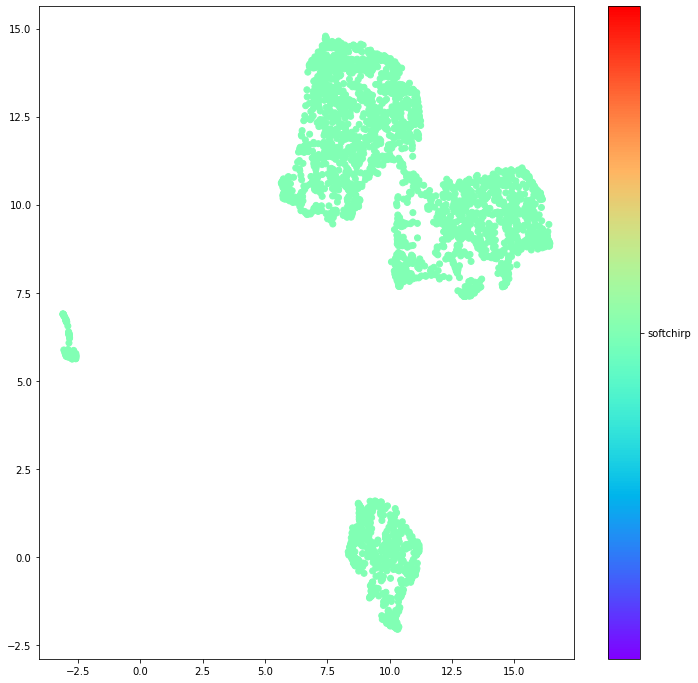

In [15]:
# Latent variables plot
plt.figure(figsize=(12, 12))

classes = ['softchirp']
colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' # options: 'M', 'F', or 'all'
ages = 'all' # set range: (0, np.inf)
ranks = 'all' 
ratids =  'all'
excludeids = None # options: '1111', or None
bodylengths = 'all'# or set range
bodylengths2 = 'all' # or set range
sounds_per_rat = [0, 10000]
types = 'single'# options for types: 'single', 'pairs', or 'all'
color_classes = True
mask =  filter_sounds_metadata_extended(sounds_metadata, ratids, excludeids, 
                                        types, colonies, weights, sexes, ages, ranks, dates,
                                        bodylengths, bodylengths2, sounds_per_rat)

if classes != 'all':
    mask *= sounds_metadata['cl'].isin(classes)
print(mask.sum())

    
transform = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, metric='euclidean', random_state=42)

latent_masked = latend_features_scaled[mask]
sounds_metadata_masked =  sounds_metadata[mask]
spec_train_aug_masked = spec_train_aug[mask]

embedding = transform.fit_transform(latent_masked)
#embedding = latent_masked[:, [2, 1]]
col_unique = sounds_metadata_masked['cl'].unique().tolist()
if color_classes:
    col_int = sounds_metadata_masked['cl'].apply(lambda x: col_unique.index(x))
else:
    col_int = sounds_metadata_masked['cl'].apply(lambda x: 1)
cmap = cm.rainbow
plt.scatter(embedding[:, 0], embedding[:, 1], c=col_int[mask], cmap=cm.rainbow)
ticks = np.arange(0, len(col_unique))
cbar = plt.colorbar(ticks =ticks)
_ = cbar.ax.set_yticklabels(col_unique)
#plt.colorbar()

In [ ]:
# Examples from a region
X_AXIS_RANGE = (9, 11)
Y_AXUS_RANGE = (5, 7)

mask_X = ((embedding[:, 0] >= X_AXIS_RANGE[0]) * (embedding[:, 0] <=  X_AXIS_RANGE[1]))
mask_Y = ((embedding[:, 1] >= Y_AXUS_RANGE[0]) * (embedding[:, 1] <=  Y_AXUS_RANGE[1]))
mask = mask_X * mask_Y

plt.figure(figsize=(12, 6))

sounds_metadata_emb = sounds_metadata_masked.reset_index(drop=True)[mask]
spec_train_emb = spec_train_aug_masked[mask]

inds = np.arange(0, len(spec_train_emb))
np.random.shuffle(inds)
print(inds.shape)
inds_plot =  inds[:6]

count = 1
for i in range(1, 4):
    plt.subplot(1, 3, count)
    plt.imshow(spec_train_emb[inds[count]])
    print(sounds_metadata_emb.iloc[inds[count]]['cl'])
    count += 1

In [ ]:
mask.sum()